In [1]:
import pandas as pd
pd.set_option('display.max_columns', 334)
pd.set_option('max_colwidth', 90)
df = pd.read_csv('play_by_play_2018.csv.gz', low_memory=False)


In [2]:
df_reg = df.loc[df['season_type']=='REG']
df_reg = df_reg.loc[df_reg.play_type.isin(['pass', 'run', 'no_play', 'punt', 'field_goal'])]
df_fg = df_reg.loc[df_reg['field_goal_attempt']==1]

In [3]:
filter_fg = df_fg[['game_id', 'posteam','week','yardline_100','half_seconds_remaining', 'field_goal_attempt', 'game_seconds_remaining', 'ydstogo', 'field_goal_result', 'kick_distance', 'score_differential', 'ep', 'epa', 'wp', 'wpa', 'weather']]

win_probs = df_fg.loc[:, df_fg.columns.str.contains('prob')]
win_probs.drop(['extra_point_prob', 'two_point_conversion_prob'], axis=1, inplace=True)
fg_data = pd.merge(filter_fg, win_probs, left_index=True, right_index=True)

C:\Python\Anaconda\lib\site-packages\pandas\core\frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


r: -0.9425788006851981


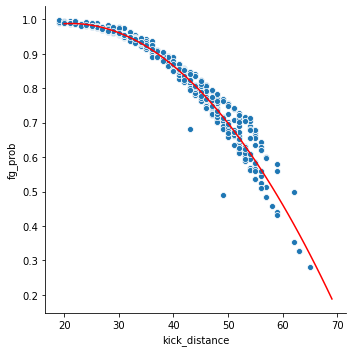

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import numpy as np

#The first reason why is might be a bad idea to kick a field goal is because there might be a low probability 
#of making it. First we'll look at field goal probability as a function of kick distance.

_ = sns.relplot(x='kick_distance', y='fg_prob', data=fg_data)
a,b,c = np.polyfit(fg_data['kick_distance'], fg_data['fg_prob'], 2)

x = np.arange(20, 70, 1)
_ = plt.plot(x, a*x**2+b*x+c, color='red')

def pearson_r(x, y):
    corr_mat = np.corrcoef(x, y)
    r = corr_mat[0,1]
    return r

corr = pearson_r(fg_data['kick_distance'],fg_data['fg_prob'])
print('r:', corr)
#First analysis suggests field goals become a worse idea the further away the kick is...duh.

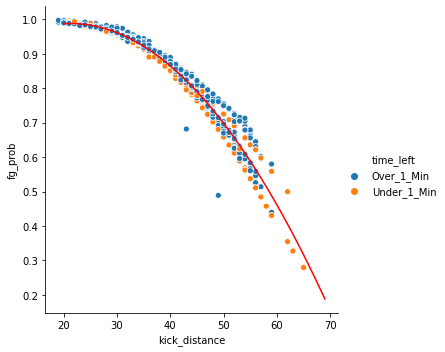

In [5]:
#However if there's no time left, there's no consequence of missing. Let's see which ones those were

fg_data.loc[fg_data['half_seconds_remaining'] > 60, 'time_left'] = 'Over_1_Min'
fg_data.loc[fg_data['half_seconds_remaining'] <= 60, 'time_left'] = 'Under_1_Min'

_ = sns.relplot(x='kick_distance', y='fg_prob', data=fg_data, hue='time_left')
a,b,c = np.polyfit(fg_data['kick_distance'], fg_data['fg_prob'], 2)

x = np.arange(20, 70, 1)
_ = plt.plot(x, a*x**2+b*x+c, color='red')

#After separating out the kicks with less than a minute left in the half, we see that most of the longest 
#kicks came with little time left, meaning they weren't necessarily bad decisions.

In [6]:
#Let's investiagte the two long ones that weren't with under a minute left in the half.
display(fg_data.loc[(fg_data['time_left']=='Over_1_Min') & (fg_data['kick_distance']>58)])


#2018_07_CLE_TB: Despite this being a low probability kick, it seems like the right decision here because there 
#were still under 2 minutes left in a tie game, and the Buccaneers needed 15 yards for a first down, so the only 
#other option really was to punt.

#2018_16_TB_DAL: This was a higher probability kick, since it was indoors, and still not a terrible decision. There
#was only 1:48 left in the half with 5 yards to go, and the field goal gave the Cowboys a chance for a 2 score lead

,game_id,posteam,week,yardline_100,half_seconds_remaining,field_goal_attempt,game_seconds_remaining,ydstogo,field_goal_result,kick_distance,score_differential,ep,epa,wp,wpa,weather,no_score_prob,opp_fg_prob,opp_safety_prob,opp_td_prob,fg_prob,safety_prob,td_prob,time_left
17727,2018_07_CLE_TB,TB,7,41.0,115.0,1.0,115.0,15,made,59.0,0.0,0.032148,2.967852,0.454732,0.545268,"Clear Temp: 79° F, Humidity: 64%, Wind: NE 7 mph",0.298514,0.083001,0.000783,0.16297,0.439681,0.000178,0.014872,Over_1_Min
42844,2018_16_TB_DAL,DAL,16,41.0,108.0,1.0,1908.0,5,made,59.0,8.0,0.632465,2.367535,0.829444,0.003104,"Temp: ° F, Wind: mph",0.168654,0.105560,0.000670,0.12894,0.579792,0.000198,0.016185,Over_1_Min


In [7]:
#Now let's investigate the two outliers

out1 = fg_data[fg_data['kick_distance'] < 50]
out2 = out1[out1['fg_prob'] < 0.69]
out3 = out2[out2['time_left'] == 'Over_1_Min']
out3
#Weather seems to play a factor with these two. In one there was a light rain and in the other there were 10mph
#winds. Despite the lower than average probability, there doesn't seem to be any other options in these cases. Both
#kicking teams were winning and facing 4th and long, so kicking a field goal made the most sense here.

,game_id,posteam,week,yardline_100,half_seconds_remaining,field_goal_attempt,game_seconds_remaining,ydstogo,field_goal_result,kick_distance,score_differential,ep,epa,wp,wpa,weather,no_score_prob,opp_fg_prob,opp_safety_prob,opp_td_prob,fg_prob,safety_prob,td_prob,time_left
6681,2018_03_DEN_BAL,BAL,3,25.0,285.0,1.0,2085.0,7,blocked,43.0,3.0,2.091635,-4.426991,0.673676,-0.119255,"Light Rain Temp: 61° F, Humidity: 91%, Wind: NNE 5 mph",0.123491,0.039455,0.000300,0.065413,0.681695,0.000824,0.088823,Over_1_Min
43861,2018_17_CIN_PIT,CIN,17,31.0,137.0,1.0,1937.0,11,made,49.0,7.0,1.363855,1.636145,0.778074,0.010429,"Partly Cloudy Temp: 42° F, Humidity: 63%, Wind: From SW 9 mph",0.269839,0.067011,0.000406,0.079106,0.488977,0.002021,0.092639,Over_1_Min


C:\Python\Anaconda\lib\site-packages\pandas\core\frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,ep
play_type,
field_goal,2.300553
no_play,0.520712
pass,1.253339
punt,-0.867124
run,1.853284


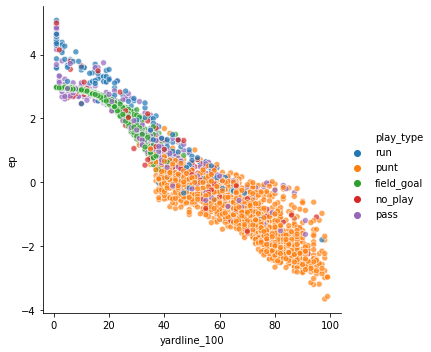

In [8]:
#To further investigate the merit of each field goal, we'll use expected points. Specifically, we want to see when 
#kicking a field goal results in fewer expected points than going for it on 4th down.

df_4th_dwn = df_reg.loc[df_reg['down']==4]
df_4th_dwn = df_4th_dwn[['game_id', 'posteam', 'yrdln','down','play_type','yardline_100', 'half_seconds_remaining','game_seconds_remaining', 'ydstogo','field_goal_attempt', 'field_goal_result', 'kick_distance', 'posteam_timeouts_remaining', 'score_differential', 'ep', 'epa', 'wp', 'wpa', 'weather']]
win_probs4 = df_reg.loc[:, df_reg.columns.str.contains('prob')]
win_probs4.drop(['extra_point_prob', 'two_point_conversion_prob'], axis=1, inplace=True)
data_4th_dwn = pd.merge(df_4th_dwn, win_probs4, left_index=True, right_index=True)

#Want to measure when expected points for going for it or punting outweighs ep for kicking field goal. Also,
#depending on point differential and time, more ep might not be worth the conservative option. 

display(data_4th_dwn.groupby('play_type').agg({'ep':'mean'}))

_ = sns.relplot(x='yardline_100', y='ep', data=data_4th_dwn, hue='play_type', alpha=0.7)


(0.0, 50.0)

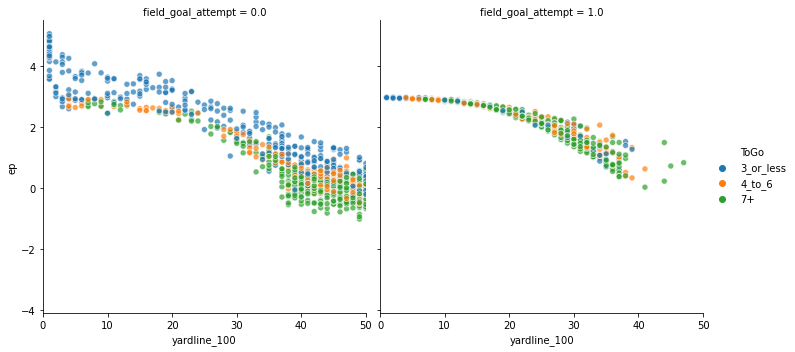

In [9]:
#Even though field goals have the highest expected points in general, there seems to be a lot of blue and purple
#above the green for pretty much every yardline. Let's take a closer look at these sorted by yards to go for a
#first down.

data_4th_dwn.loc[data_4th_dwn['ydstogo']<=3, 'ToGo'] = '3_or_less'
data_4th_dwn.loc[(data_4th_dwn['ydstogo']<=6) & (data_4th_dwn['ydstogo']>=4), 'ToGo'] = '4_to_6'
data_4th_dwn.loc[data_4th_dwn['ydstogo']>6, 'ToGo'] = '7+'
_ = sns.relplot(x='yardline_100', y='ep', data=data_4th_dwn, hue='ToGo', col='field_goal_attempt', alpha=0.7)
plt.xlim(0, 50)

In [10]:
#Here we define bootstrap functions to evaluate the means of expected points for each to go distance and chunk of
#yardlines. 

def bs_rep_1d(data, func):
    bs_sample = np.random.choice(data, len(data))
    return func(bs_sample)

def draw_bs_reps(data, func, size=1):
    
    bs_replicates = np.empty(size)
    
    for i in range(size):
        bs_replicates[i] = bs_rep_1d(data, func)
    return bs_replicates

In [11]:
p = []
vals = np.arange(5, 45, 5)

for i in vals:
    inside_40 = data_4th_dwn[(data_4th_dwn['yardline_100']<=i) & (data_4th_dwn['yardline_100']>=i-5)]
    short_inside_40 = inside_40[inside_40['ToGo']=='3_or_less']
    display(inside_40[inside_40['ToGo']=='3_or_less'].groupby('field_goal_attempt').agg({'ep':'mean'}))

    bs_ep_nofg = draw_bs_reps(short_inside_40[short_inside_40['field_goal_attempt']==0]['ep'], np.mean, size=10000)
    bs_ep_fg = draw_bs_reps(short_inside_40[short_inside_40['field_goal_attempt']==1]['ep'], np.mean, size=10000)

    p.append(np.sum(bs_ep_fg-bs_ep_nofg<0)/len(bs_ep_fg))

print('p-value:',p)

#When looking at plays inside the 40 yardline, in 5 yard chunks, the bootstrap analysis shows that it is 
#virtually always worth it to go for it on 4th and short. I chose the 40 yardline because it corresponds to a 58yd
#field goal, which is about the longest that kickers can make (only 5 were hit from further than that in 2018). 


,ep
field_goal_attempt,
0.0,4.053966
1.0,2.961184


,ep
field_goal_attempt,
0.0,3.351582
1.0,2.915164


,ep
field_goal_attempt,
0.0,3.201720
1.0,2.823444


,ep
field_goal_attempt,
0.0,3.181118
1.0,2.608307


,ep
field_goal_attempt,
0.0,2.813919
1.0,2.365987


,ep
field_goal_attempt,
0.0,2.309959
1.0,1.933702


,ep
field_goal_attempt,
0.0,1.748724
1.0,1.450217


,ep
field_goal_attempt,
0.0,1.246571
1.0,1.099790


p-value: [1.0, 1.0, 1.0, 1.0, 1.0, 0.9997, 0.9916, 0.8778]


In [12]:
p = []
vals = np.arange(5,40,5)

for i in vals:

    inside_35 = data_4th_dwn[(data_4th_dwn['yardline_100']<=i) & (data_4th_dwn['yardline_100']>=i-5)]
    med_inside_35 = inside_35[inside_35['ToGo']=='4_to_6']
    display(inside_35[inside_35['ToGo']=='4_to_6'].groupby('field_goal_attempt').agg({'ep':'mean'}))

    bs_ep_nofg = draw_bs_reps(med_inside_35[med_inside_35['field_goal_attempt']==0]['ep'], np.mean, size=10000)
    bs_ep_fg = draw_bs_reps(med_inside_35[med_inside_35['field_goal_attempt']==1]['ep'], np.mean, size=10000)

    p.append(np.sum(bs_ep_fg-bs_ep_nofg<0)/len(bs_ep_fg))

print('p-values:',p)

#When we look at 4th and medium (4 to 6 yards), the mean behaves weirdly at 25 yards out. This is likely due 
#to some irregularity in the data because logically it doesn't make sense witht he rest of the results. As these
#p-values show, it is pretty much never worth it to go for it on 4th and medium, even when inside the 10 yardline

,ep
field_goal_attempt,
0.0,2.834720
1.0,2.950633


,ep
field_goal_attempt,
0.0,2.825909
1.0,2.920033


,ep
field_goal_attempt,
0.0,2.721646
1.0,2.826034


,ep
field_goal_attempt,
0.0,2.587832
1.0,2.649233


,ep
field_goal_attempt,
0.0,2.471671
1.0,2.330359


,ep
field_goal_attempt,
0.0,1.777174
1.0,1.915753


,ep
field_goal_attempt,
0.0,1.390721
1.0,1.502755


p-values: [0.0088, 0.0032, 0.0028, 0.0044, 0.994, 0.0025, 0.0673]


In [13]:
p = []
vals = np.arange(10,40,5)

for i in vals:

    inside_35 = data_4th_dwn[(data_4th_dwn['yardline_100']<i) & (data_4th_dwn['yardline_100']>=i-5)]
    lng_inside_35 = inside_35[inside_35['ToGo']=='7+']
    display(inside_35[inside_35['ToGo']=='7+'].groupby('field_goal_attempt').agg({'ep':'mean'}))

    bs_ep_nofg = draw_bs_reps(lng_inside_35[lng_inside_35['field_goal_attempt']==0]['ep'], np.mean, size=10000)
    bs_ep_fg = draw_bs_reps(lng_inside_35[lng_inside_35['field_goal_attempt']==1]['ep'], np.mean, size=10000)

    p.append(np.sum(bs_ep_fg-bs_ep_nofg<0)/len(bs_ep_fg))

print('p-values:',p)

#For the sake of thoroughness I ran this again with 4th and long, but unsurprisingly we see that it's never worth
#it to go for it on 4th and long (7+ yards). Although the probabilites do seem surprisngly high for the 25 and 
# 30 yardlines

,ep
field_goal_attempt,
0.0,2.779360
1.0,2.916369


,ep
field_goal_attempt,
0.0,2.683976
1.0,2.834238


,ep
field_goal_attempt,
0.0,2.482314
1.0,2.660094


,ep
field_goal_attempt,
0.0,2.333108
1.0,2.349436


,ep
field_goal_attempt,
0.0,1.867235
1.0,1.943399


,ep
field_goal_attempt,
0.0,1.259229
1.0,1.427615


p-values: [0.0, 0.0, 0.0, 0.3656, 0.1026, 0.0235]


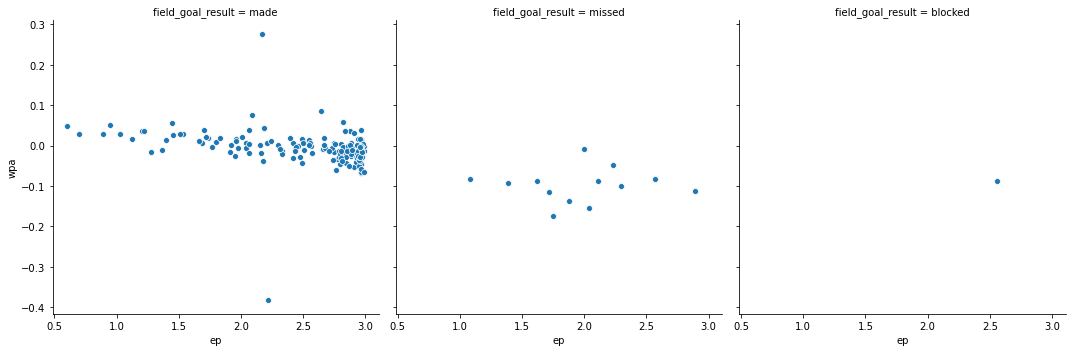

In [14]:
#From the bootstrap analysis we can conclude that kicking a field goal on 4th and short from inside the 40 yardline
#is almost always not worth in in terms of expected points. Now let's look at some other factors to see which of 
#these field goals was the worst.

#First let's look at win probability adjusted, specifically where it's negative
inside_40_all = data_4th_dwn[(data_4th_dwn['yardline_100']<=40)]
shrt_inside_40 = inside_40_all[inside_40_all['ToGo']=='3_or_less']
short_i40_fgs = shrt_inside_40[shrt_inside_40['field_goal_attempt']==1]

_ = sns.relplot(x='ep', y='wpa', data=short_i40_fgs, col='field_goal_result')

In [15]:
#Of course, missing a field goal or having blocked will decrease a team's win probability even if kicking a field
#goal was the right decision. Since there aren't very many of them let's inspect them further and see if they were
#good calls

misseds = short_i40_fgs[short_i40_fgs['field_goal_result']!='made']
misseds[['game_id', 'posteam', 'yardline_100', 'game_seconds_remaining', 'ydstogo', 'kick_distance', 'score_differential', 'wpa','weather']].sort_values('wpa')

#2018_13_ARI_GB: Not bad, there was only 3 seconds left and a field goal is certainly more likely than scoring a TD 
#from the 31yd line, even in bad weather
#2018_01_PIT_CLE: Not terrible, just 1:47 left and tied, so a field goal would've made a win very likely here, 
#though it was raining
#2018_03_TEN_JAX: Just two seconds remaining in the half, so not bad
#2018_03_LAC_LA: Only 4 seconds left in half, and already up by 8
#2018_01_TB_NO: Not much time left and a 16 point lead, so a fg would've put the game away
#Aside from these 5, the other 8 are still candidates for the worst fg

,game_id,posteam,yardline_100,game_seconds_remaining,ydstogo,kick_distance,score_differential,wpa,weather
29785,2018_12_GB_MIN,MIN,30.0,2080.0,2,48.0,0.0,-0.173568,"N/A (Indoors) Temp: ° F, Wind: mph"
31842,2018_13_ARI_GB,GB,31.0,3.0,1,49.0,-3.0,-0.154000,"Snow Temp: 34° F, Humidity: 92%, Wind: N-NE 20 mph"
29098,2018_12_ARI_LAC,ARI,28.0,2385.0,3,46.0,3.0,-0.136802,"Partly Cloudy Temp: 74° F, Humidity: 52%, Wind: N 3 mph"
27428,2018_11_GB_SEA,GB,29.0,3351.0,3,47.0,7.0,-0.113877,"Partly Cloudy Temp: 54° F, Humidity: 69%, Wind: South 6 mph"
13524,2018_05_MIN_PHI,MIN,10.0,3223.0,2,28.0,0.0,-0.111994,"Partly Cloudy Temp: 79° F, Humidity: 77%, Wind: WSW 6 mph"
2075,2018_01_PIT_CLE,PIT,24.0,107.0,3,42.0,0.0,-0.099274,"Rain Temp: 58° F, Humidity: 84%, Wind: East 11 mph"
25476,2018_10_JAX_IND,JAX,34.0,962.0,3,52.0,-6.0,-0.092130,"Sunny Temp: 38° F, Humidity: 46%, Wind: S 10 mph"
13402,2018_05_MIA_CIN,CIN,19.0,2038.0,2,37.0,-7.0,-0.088606,"Mostly Sunny Temp: 87° F, Humidity: 52%, Wind: S 4 mph"
9379,2018_04_CLE_OAK,LV,29.0,2570.0,2,47.0,4.0,-0.088418,"Partly Cloudy Temp: 71° F, Humidity: 58%, Wind: W 8 mph"
8697,2018_03_TEN_JAX,TEN,30.0,1802.0,1,48.0,0.0,-0.088344,"Temp: 89° F, Humidity: 61%, Wind: EAST 10MPH mph"


In [16]:
#Now let's look at made fgs
#Important metrics: yardline, game time remaining, yards to go, kick distance, and score differential

mades = short_i40_fgs[short_i40_fgs['field_goal_result']=='made']
bad_mades = mades[mades['wpa']<=0]
bad_mades_cl = bad_mades[['game_id', 'posteam', 'yardline_100','half_seconds_remaining', 'game_seconds_remaining', 'ydstogo', 'kick_distance', 'score_differential','wp', 'wpa']]

bad_mades_cl.loc[bad_mades_cl['score_differential']<=np.absolute(16), 'scores'] = '2_or_less'
bad_mades_cl.loc[bad_mades_cl['score_differential']>np.absolute(16), 'scores'] = '2+'


#Let's look at win percentage adjusted over win percentage to see how much kicking a field goal hurt the team's 
#original chances of winning
bad_mades_cl['wp%-']=(bad_mades_cl['wpa'])/bad_mades_cl['wp']
bad_mades_cl[bad_mades_cl['scores']=='2_or_less'].sort_values('wp%-').head(20)

two_scores = bad_mades_cl[bad_mades_cl['scores']=='2_or_less']
close_2_score = two_scores[two_scores['yardline_100']<10]

close_2_score = close_2_score.drop(close_2_score[(close_2_score.score_differential <= 3)&(close_2_score.score_differential >= -3)].index)

close_2_score.sort_values('wp%-').head(10)

#These last few edits may be a little more subjective, but basically I find it hard to bash a coach for kicking a 
#field goal on 4th down when outside the opponent's 10 and the score differential is only 1 field goal in either
#direction. If up by 3 or fewer, making it requires the other team to score a touchdown, if down by 3 or fewer,
#making it ties or puts your team in the lead. Therefore I would say this dataframe of 10 kicks, when down by more 
#than three and inside the opponent's 10 yard line (with 3 or fewer yards for a first down) are truly the worst
#kicks of the 2018 NFL season.

#Note: applying these filters to the missed FGs dataframe filters them all out, so we don't need to worry about
#those anymore.

C:\Python\Anaconda\lib\site-packages\pandas\core\indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Python\Anaconda\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
<ipython-input-16-8c272840735e>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https

,game_id,posteam,yardline_100,half_seconds_remaining,game_seconds_remaining,ydstogo,kick_distance,score_differential,wp,wpa,scores,wp%-
32546,2018_13_CHI_NYG,CHI,3.0,75.0,75.0,3,21.0,-10.0,0.047460,-0.037029,2_or_less,-0.780201
8315,2018_03_PIT_TB,TB,3.0,77.0,1877.0,3,21.0,-16.0,0.158366,-0.040853,2_or_less,-0.257968
23849,2018_09_PIT_BAL,BAL,5.0,280.0,2080.0,3,23.0,-11.0,0.277075,-0.049498,2_or_less,-0.178646
3805,2018_02_DET_SF,DET,9.0,6.0,1806.0,2,27.0,-6.0,0.329049,-0.053659,2_or_less,-0.163073
12105,2018_05_BAL_CLE,BAL,7.0,956.0,956.0,3,25.0,-6.0,0.322262,-0.039598,2_or_less,-0.122876
16202,2018_06_PHI_NYG,NYG,3.0,348.0,2148.0,3,21.0,-11.0,0.260542,-0.031934,2_or_less,-0.122566
14059,2018_05_TEN_BUF,TEN,7.0,999.0,2799.0,3,25.0,-7.0,0.309167,-0.026714,2_or_less,-0.086406
27198,2018_11_DAL_ATL,ATL,3.0,508.0,508.0,2,21.0,-10.0,0.131974,-0.008937,2_or_less,-0.067715
39078,2018_15_NO_CAR,NO,6.0,600.0,2400.0,3,24.0,-4.0,0.422599,-0.025824,2_or_less,-0.061107
1763,2018_01_NYJ_DET,DET,3.0,15.0,1815.0,3,21.0,-10.0,0.292224,-0.013226,2_or_less,-0.045260


In [17]:
#Here's a look at the more consequential kicks and plays preceding them. Because we have the benefit of hindsight
#this perhaps isn't the best way to decide whether or not to kick a field goal during a game, but since we're 
#looking for the worst kick of 2018 after the fact, I think this is appropriate.

df_reg.loc[(df_reg['game_id']=='2018_13_CHI_NYG') & (df_reg['game_seconds_remaining']<=100)]
#While kicking a field goal first when down by 10 this late is a typical strategy, the Bears wasted time by running
#3 plays inside the 10 before kicking the field goal. It worked out for the Bears though who recovered and drove 
#for a game tying touchdown as time expired. They lost in overtime though by 3.

df_reg.loc[(df_reg['game_id']=='2018_03_PIT_TB') & (df_reg['half_seconds_remaining']<=100)]
#Down by 16 at the three yardline in the first half with a real chance to come back, a field goal does nothing
#for the Buccaneers here. They missed out on 4 points here, and lost the game by 3

df_reg.loc[(df_reg['game_id']=='2018_05_BAL_CLE') & (df_reg['game_seconds_remaining']<=1100)].head(20)
#Ravens lose by 3 after choosing to kick a field goal on 4th and 3 from the 7 while down 6.

df_reg.loc[(df_reg['game_id']=='2018_05_TEN_BUF') & (df_reg['game_seconds_remaining']<=2900)].head(20)
#Titans lose by 1 after kicking a field goal on 4th and 3 from the 7 while down 7. This one is early enough in the
#game that it seems more forgivable than the others

df_reg.loc[(df_reg['game_id']=='2018_11_DAL_ATL') & (df_reg['game_seconds_remaining']<=700)].head(20)
#Falcons lose by 3 after kicking a field goal on 4th and 2 at the 3 yardline. They actually managed to get the ball
#back and score a touchdown to tie the game, but then allowed a game winning field goal on the next drive.

df_reg.loc[(df_reg['game_id']=='2018_15_NO_CAR') & (df_reg['game_seconds_remaining']<=2650)].head(20)
#Saints win by 3 after kicking a field goal on 4th and 3 from the 6 yardline when down by 4. This is an interesting
#one to judge because of how early it happened in the game. Depending on offensive and defensive ranks of the 
#Saints and Panthers, this could've been a little lucky given how inept both offenses were in this game

,play_id,game_id,old_game_id,home_team,away_team,season_type,week,posteam,posteam_type,defteam,side_of_field,yardline_100,game_date,quarter_seconds_remaining,half_seconds_remaining,game_seconds_remaining,game_half,quarter_end,drive,sp,qtr,down,goal_to_go,time,yrdln,ydstogo,ydsnet,desc,play_type,yards_gained,shotgun,no_huddle,qb_dropback,qb_kneel,qb_spike,qb_scramble,pass_length,pass_location,air_yards,yards_after_catch,run_location,run_gap,field_goal_result,kick_distance,extra_point_result,two_point_conv_result,home_timeouts_remaining,away_timeouts_remaining,timeout,timeout_team,td_team,posteam_timeouts_remaining,defteam_timeouts_remaining,total_home_score,total_away_score,posteam_score,defteam_score,score_differential,posteam_score_post,defteam_score_post,score_differential_post,no_score_prob,opp_fg_prob,opp_safety_prob,opp_td_prob,fg_prob,safety_prob,td_prob,extra_point_prob,two_point_conversion_prob,ep,epa,total_home_epa,total_away_epa,total_home_rush_epa,total_away_rush_epa,total_home_pass_epa,total_away_pass_epa,air_epa,yac_epa,comp_air_epa,comp_yac_epa,total_home_comp_air_epa,total_away_comp_air_epa,total_home_comp_yac_epa,total_away_comp_yac_epa,total_home_raw_air_epa,total_away_raw_air_epa,total_home_raw_yac_epa,total_away_raw_yac_epa,wp,def_wp,home_wp,away_wp,wpa,home_wp_post,away_wp_post,vegas_wp,vegas_home_wp,total_home_rush_wpa,total_away_rush_wpa,total_home_pass_wpa,total_away_pass_wpa,air_wpa,yac_wpa,comp_air_wpa,comp_yac_wpa,total_home_comp_air_wpa,total_away_comp_air_wpa,total_home_comp_yac_wpa,total_away_comp_yac_wpa,total_home_raw_air_wpa,total_away_raw_air_wpa,total_home_raw_yac_wpa,total_away_raw_yac_wpa,punt_blocked,first_down_rush,first_down_pass,first_down_penalty,third_down_converted,third_down_failed,fourth_down_converted,fourth_down_failed,incomplete_pass,touchback,interception,punt_inside_twenty,punt_in_endzone,punt_out_of_bounds,punt_downed,punt_fair_catch,kickoff_inside_twenty,kickoff_in_endzone,kickoff_out_of_bounds,kickoff_downed,kickoff_fair_catch,fumble_forced,fumble_not_forced,fumble_out_of_bounds,solo_tackle,safety,penalty,tackled_for_loss,fumble_lost,own_kickoff_recovery,own_kickoff_recovery_td,qb_hit,rush_attempt,pass_attempt,sack,touchdown,pass_touchdown,rush_touchdown,return_touchdown,extra_point_attempt,two_point_attempt,field_goal_attempt,kickoff_attempt,punt_attempt,fumble,complete_pass,assist_tackle,lateral_reception,lateral_rush,lateral_return,lateral_recovery,passer_player_id,...,lateral_receiver_player_name,lateral_rusher_player_id,lateral_rusher_player_name,lateral_sack_player_id,lateral_sack_player_name,interception_player_id,interception_player_name,lateral_interception_player_id,lateral_interception_player_name,punt_returner_player_id,punt_returner_player_name,lateral_punt_returner_player_id,lateral_punt_returner_player_name,kickoff_returner_player_name,kickoff_returner_player_id,lateral_kickoff_returner_player_id,lateral_kickoff_returner_player_name,punter_player_id,punter_player_name,kicker_player_name,kicker_player_id,own_kickoff_recovery_player_id,own_kickoff_recovery_player_name,blocked_player_id,blocked_player_name,tackle_for_loss_1_player_id,tackle_for_loss_1_player_name,tackle_for_loss_2_player_id,tackle_for_loss_2_player_name,qb_hit_1_player_id,qb_hit_1_player_name,qb_hit_2_player_id,qb_hit_2_player_name,forced_fumble_player_1_team,forced_fumble_player_1_player_id,forced_fumble_player_1_player_name,forced_fumble_player_2_team,forced_fumble_player_2_player_id,forced_fumble_player_2_player_name,solo_tackle_1_team,solo_tackle_2_team,solo_tackle_1_player_id,solo_tackle_2_player_id,solo_tackle_1_player_name,solo_tackle_2_player_name,assist_tackle_1_player_id,assist_tackle_1_player_name,assist_tackle_1_team,assist_tackle_2_player_id,assist_tackle_2_player_name,assist_tackle_2_team,assist_tackle_3_player_id,assist_tackle_3_player_name,assist_tackle_3_team,assist_tackle_4_player_id,assist_tackle_4_player_name,assist_tackle_4_team,pass_defense_1_player_id,pass_defense_1_player_

In [18]:
#To get a little more context, let's look at the offensive and defensive rankings of each team
dfo = pd.read_csv(r'C:/Users/jedbe/OneDrive/DataRasgo/PracticeData/Off_3rd_short_2018.csv', skiprows=1)
dfo = dfo.drop(['G', 'Year', 'Unnamed: 28', 'Down & Yards to Go'], axis=1)

dfd = pd.read_csv(r'C:/Users/jedbe/OneDrive/DataRasgo/PracticeData/Def_3rd_short_2018.csv', skiprows=1)
dfd = dfd.drop(['G', 'Year', 'Unnamed: 28', 'Down & Yards to Go'], axis=1)

In [19]:
dfo['conv_rate'] = dfo['1D']/dfo['#Pl']
dfo['Pass_Rank'] = dfo['Y/A?'].rank(method='min', ascending=False)
dfo['Rush_Rank'] = dfo['Y/A'].rank(method='min', ascending=False)
dfo['Conv_Rank'] = dfo['conv_rate'].rank(method='min', ascending=False)

dfo_ordered = dfo[['Tm','Y/A?', 'Pass_Rank', 'Y/A', 'Rush_Rank','#Pl', '1D','conv_rate', 'Conv_Rank']].sort_values('conv_rate', ascending=False)
dfo_ordered

,Tm,Y/A?,Pass_Rank,Y/A,Rush_Rank,#Pl,1D,conv_rate,Conv_Rank
3,Ravens,7.1,4.0,5.1,1.0,63,49,0.777778,1.0
2,Giants,8.5,3.0,1.9,27.0,40,29,0.725000,2.0
16,Panthers,6.1,16.0,3.3,16.0,52,37,0.711538,3.0
0,Jaguars,9.1,1.0,3.8,10.0,66,45,0.681818,4.0
15,Cowboys,6.1,16.0,3.8,10.0,60,40,0.666667,5.0
1,Chiefs,9.0,2.0,3.5,14.0,50,33,0.660000,6.0
8,Colts,6.6,9.0,4.6,5.0,73,48,0.657534,7.0
21,Saints,5.0,22.0,3.1,19.0,66,42,0.636364,8.0
5,Buccaneers,7.0,6.0,4.2,6.0,48,30,0.625000,9.0
10,Steelers,6.4,11.0,3.2,17.0,58,36,0.620690,10.0


In [20]:
dfd['conv_rate_allowed'] = dfd['1D']/dfd['#Pl']
dfd['Pass_Rank'] = dfd['Y/A?'].rank(method='min')
dfd['Rush_Rank'] = dfd['Y/A'].rank(method='min')
dfd['Conv_Rank'] = dfd['conv_rate_allowed'].rank(method='min')

dfd_ordered = dfd[['Tm','Y/A?', 'Pass_Rank', 'Y/A', 'Rush_Rank','#Pl', '1D','conv_rate_allowed', 'Conv_Rank']].sort_values('conv_rate_allowed', ascending=True)
dfd_ordered

,Tm,Y/A?,Pass_Rank,Y/A,Rush_Rank,#Pl,1D,conv_rate_allowed,Conv_Rank
26,49ers,3.9,6.0,2.1,3.0,58,26,0.448276,1.0
30,Seahawks,3.2,2.0,2.8,13.0,53,24,0.452830,2.0
19,Jets,4.3,12.0,1.3,1.0,56,26,0.464286,3.0
25,Ravens,4.0,7.0,3.7,24.0,41,20,0.487805,4.0
28,Packers,3.5,4.0,2.7,10.0,62,32,0.516129,5.0
17,Titans,4.6,15.0,3.8,25.0,58,30,0.517241,6.0
29,Rams,3.2,2.0,6.2,31.0,43,23,0.534884,7.0
31,Broncos,2.9,1.0,3.5,21.0,64,35,0.546875,8.0
23,Bears,4.1,9.0,3.0,16.0,61,34,0.557377,9.0
6,Browns,7.3,26.0,2.1,3.0,61,34,0.557377,9.0


Text(0.5, 1.0, 'Def Conversion Rank')

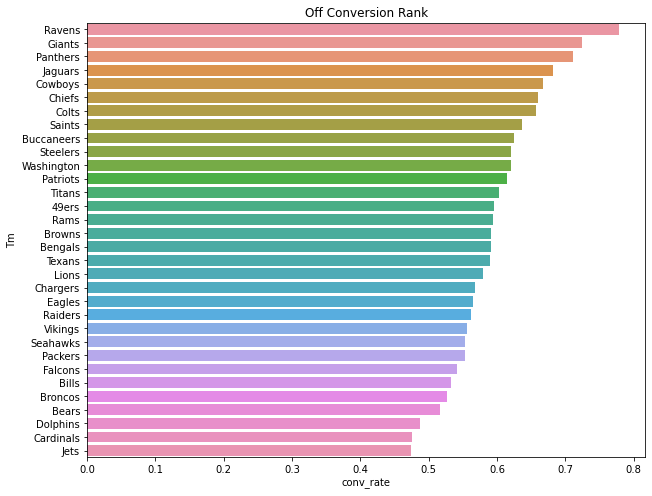

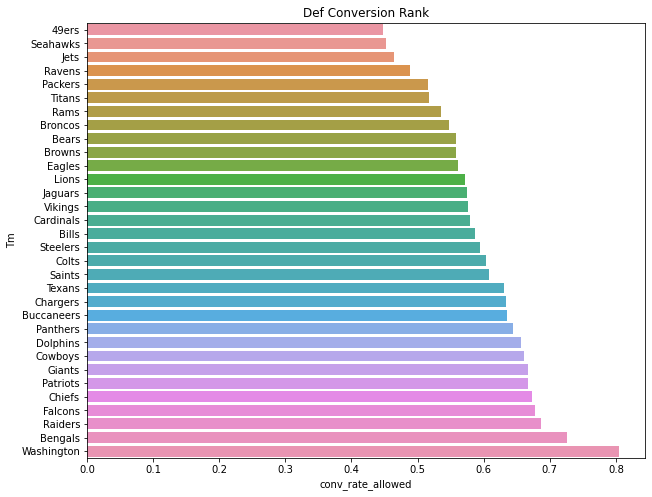

In [21]:
plt.figure(figsize=(10,8))
_ = sns.barplot(x='conv_rate', y='Tm', data=dfo_ordered)
plt.title('Off Conversion Rank')

plt.figure(figsize=(10,8))
_ = sns.barplot(x='conv_rate_allowed', y='Tm', data=dfd_ordered)
plt.title('Def Conversion Rank')

In [22]:
#Here are the offensive and defensive rankings for 3rd and short. I chose these over 4th and short because they 
#are a much greater sample size, and teams generally treat them similarly, as in they know they need to convert 
#on the next play.

#The Bears rank 29th in PYA (3.6) and 23rd in RYA (2.7), so it makes sense that they didn't trust their offense to 
#convert against the Giants. However, the Giants allow the 2nd most PYA (10.0) and 3rd most RYA (5.8), so it was 
#probably worth the risk. The Bears were also 29th in conv. rate, while the Giants were 26th in conv. rate allowed.

#The Buccaneers ranked 6th in both PYA (7.0) and RYA (4.2), while the Steelers were 10th defensively in PYA (4.3) 
#and 14th in RYA (2.7), making their decision still pretty bad. Theirs was probably the worst kick on 2018.
#The Buccaneers were also 9th in conversion rate while the Steelers were 17th in conv. rate allowed.

#The Ravens ranked 4th in PYA (7.1) and tied for 1st in RYA (5.1). The Browns were 5th defensively in RYA (2.1) 
#but 26th against PYA (7.3). The Ravens were also 1st in conv. rate while the Browns were 9th in conv. rate 
#allowed. This is probably the second worst kick. 

#Titans were 18th in PYA (5.9) and 14th in RYA (3.5) and the Bills were 10th and 11th in PYA (4.2) and RYA (2.7) 
#respectively. The Titans were 13th in conv. rate and the Bills were 16th in conv. rate allowed. This is a close
#call. 

#Falcons were 20th in PYA (5.3) but 3rd in RYA (5.0) while the Cowboys were 22nd in PYA (6.9) against, but 7th 
#in RYA (2.4), so this would've been a close call. The Falcons were also 26th in conv. rate and the Cowboys were
#25th in conv. rate allowed.

#The Saints were 19th in RYA (3.1) and 22nd in PYA (5.0), and the Panthers were 24th in PYA (7.0) against and 
#last in RYA (7.6) against. However the Saints were 8th in conv. rate while the Panthers were 23rd in conv. rate
#allowed. 

#Further interest: I'm interested in seeing if there's a way to calculate expected net yards per play taking into 
#account a team's offensive Y/A average against another team's defensive Y/A allowed average

#Also, perhaps looks at the opposing team's expected points if you were to miss and the probability of missing. This
#would look at longer field goals.

,ep
field_goal_attempt,
0.0,3.906723
1.0,2.947181


p-value: 1.0


,game_id,posteam,yardline_100,half_seconds_remaining,game_seconds_remaining,ydstogo,kick_distance,score_differential,wp,wpa,scores,wp%-
8315,2018_03_PIT_TB,TB,3.0,77.0,1877.0,3,21.0,-16.0,0.158366,-0.040853,2_or_less,-0.257968


,Tm,Y/A?,Pass_Rank,Y/A,Rush_Rank,#Pl,1D,conv_rate,Conv_Rank
5,Buccaneers,7.0,6.0,4.2,6.0,48,30,0.625,9.0


,Tm,Y/A?,Pass_Rank,Y/A,Rush_Rank,#Pl,1D,conv_rate_allowed,Conv_Rank
18,Steelers,4.3,12.0,2.7,10.0,37,22,0.594595,17.0


Expected Pass Yards: 5.65
Expected Rush Yards: 3.45


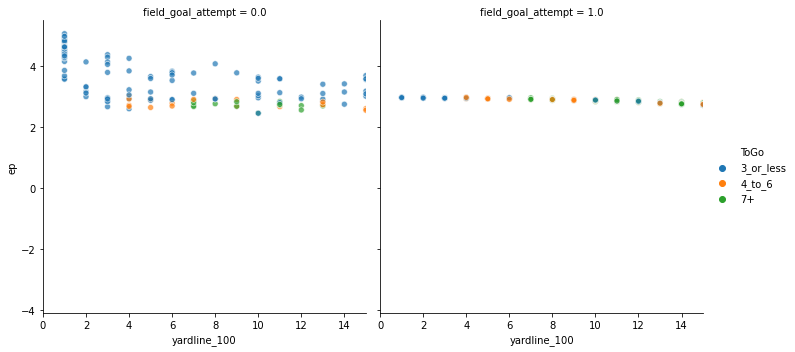

In [23]:
#5 minute pitch to Dirk Koetter (Buc's coach, 2018). 

#First, the expected points for all non-field goal attempts inside the ten yardline with 3 or fewer yards to go is 
#much higher than the expected points for field goal attempts. This is clearly shown in the graph below.
_ = sns.relplot(x='yardline_100', y='ep', data=data_4th_dwn, hue='ToGo', col='field_goal_attempt', alpha=0.7)
plt.xlim(0, 15)


#This is then proven with this bootstrap analysis of mean expected points for field goal attempts versus non-field
#goal attempts. In 10,000 trials, 0 resulted in the average expected points of field goals being highed than the 
#average expected points of runs or passes. 
inside_10 = data_4th_dwn[(data_4th_dwn['yardline_100']<=10)]
short_inside_10 = inside_10[inside_10['ToGo']=='3_or_less']
display(inside_10[inside_10['ToGo']=='3_or_less'].groupby('field_goal_attempt').agg({'ep':'mean'}))

bs_ep_nofg = draw_bs_reps(short_inside_10[short_inside_10['field_goal_attempt']==0]['ep'], np.mean, size=10000)
bs_ep_fg = draw_bs_reps(short_inside_10[short_inside_10['field_goal_attempt']==1]['ep'], np.mean, size=10000)

p  = np.sum(bs_ep_nofg>bs_ep_fg)/len(bs_ep_fg)

print('p-value:',p)

#At the end of the first half, down by 16, the Bucs really needed a touchdown from the three yardline to get back 
#in the game.
display(close_2_score.loc[close_2_score['game_id']=='2018_03_PIT_TB'])

#Comparing the Buc's offense to the Steeler's defense on 3rd and short (for better sample size), the expected pass
#and rush yards both result in a touchdown for the Buc's. Also their conversion rate is very close to the rate 
#allowed by the Steelers. 
display(dfo_ordered.loc[dfo_ordered['Tm']=='Buccaneers'])
display(dfd_ordered.loc[dfd_ordered['Tm']=='Steelers'])
print('Expected Pass Yards:', 11.3/2)
print('Expected Rush Yards:', 6.9/2)

#Therefore, going for it on 4th and goal from the three would've been a better option than kicking a field goal. 

In [24]:
#Here is an index I created to quantify how bad a field goal attempt was given the yardline, time left in the half,
#the score, and the yards to go for a first down. The point of this index is to show easily identifiable outliers,
#which is why I primairly use exponential equations.

def bad_fg_index(df):
    scores = []
    for index, item in df.iterrows():
        
        #The first component is the yardline. For each yard inside the 30, the kicking team receives a 10% penalty
        #per yard times 1.5. This constant is there to appropriately weight the penalty for the yardline component
        #as it's supposed to be the most consequential of the four since it is most directly responsible for the 
        #expected points of a play.
        
        if (item['yardline_100'] <= 30):
            ydscore = 1.1**(1.5*(30-item['yardline_100']))
        
        #For kicks from beyond the 30 yardline, the kicking team receives a penalty of ((x-20)*0.1)^3. This is 
        #much gentler than the penalty inside the 30, but still penalizes teams for trying absurdly long field
        #goals. I chose the 30 yardline because, based on expected points, that's where it's no longer always worth
        #it to go for it.
        
        elif (item['yardline_100'] > 30):
            ydscore = ((item['yardline_100']-20)*0.1)**3
    
        #The next component is time remaining in the half. Until there are two minutes left in the half, the score
        #gradually increases following the equation (10/325)*((1800-t)*0.01)^2 +1. This caps the score at approx.
        #9, which, compared to the yardline score, I believe is a reasonable weight. 
        
        if (item['half_seconds_remaining'] > 120):
            time_score = ((10/325)*((1800-item['half_seconds_remaining'])*0.01)**2)+1
            
        #Under 2 minutes, the score gradually decreases back to 1 following the equation (t*0.024557)^2 +1. This 
        #constant was chosen to make sure this equation intersects with the other one at 120 seconds. This score 
        #reaches its maximum at 120 seconds because at that point in the game there is still enough time left to
        #drive down the field and score a touchdown, and depending on the score, that might be much more helpful 
        #than a field goal. As the time winds down however, there is only enough time left to kick a field goal.
    
        elif (item['half_seconds_remaining'] <= 120):
            time_score = ((item['half_seconds_remaining']*.024557)**2)+1
    
    
        #The remaining scores are just multipliers so they are much simpler. If teams are trailing by more than 16
        #and kicking a field goal they've likely given up on the win and are just trying to salvage some dignity, 
        #so they get their score reduced by half. 
        
        if (item['score_differential'] < (-16)):
            diff_score = 0.5
            
        #If a team is trailing by between less than 17 and more than 3, then they really need a touchdown more 
        #than a field goal, so they get no score reduction. 
        
        elif ((item['score_differential'] >= -16) & (item['score_differential'] < -3)):
            diff_score = 1
        
        #If a team trails or leads by a field goal or less, getting a field goal will either tie, put them in a
        #small lead, or increase their lead by more than a  field goal, making these generally good decisions. 
        #Therefore is receives a deduction of 3/4.
        elif ((item['score_differential'] >= -3) & (item['score_differential'] <= 3)):
            diff_score = 0.25
        
        #Finally if a team leads by more than a field goal already, adding another field goal doesn't have any 
        #immediate consequences so they get a reduction of 4/5.
        
        elif (item['score_differential'] > 3):
            diff_score = 0.2
        
        #The fourth component is yards to go for a first down. On 4th and short it is usually worth it in terms of
        #expected points to go for it, so this receives no deduction. 
        
        if (item['ydstogo'] <= 3):
            togoscore = 1
        
        #Fourth and medium is typically not worth it in terms of expected points, but sometimes could be the better
        #option if they are close enough to the goal line, so it receives a deduction of 1/2.
        
        elif ((item['ydstogo'] > 3) & (item['ydstogo'] <= 6)):
            togoscore = 0.5
            
        #Fourth and long is almost never worth going for, so a field goal here earns a 3/4 deduction.
        
        elif (item['ydstogo'] >= 7):
            togoscore=0.25
            
        #Finally we mulptiply the score together to get the final index.
        scores.append(ydscore*time_score*diff_score*togoscore)  
    
    return scores
    

In [25]:
#The bootstrap analysis used to show that the 30 yard line is where the expected points trade off between kicking 
#a field goal and going for it occurs. 

p = []
vals = np.arange(5, 45, 5)

for i in vals:
    inside_40 = data_4th_dwn[(data_4th_dwn['yardline_100']<=i) & (data_4th_dwn['yardline_100']>=i-5)]
    display(inside_40.groupby('field_goal_attempt').agg({'ep':'mean'}))

    bs_ep_nofg = draw_bs_reps(inside_40[inside_40['field_goal_attempt']==0]['ep'], np.mean, size=10000)
    bs_ep_fg = draw_bs_reps(inside_40[inside_40['field_goal_attempt']==1]['ep'], np.mean, size=10000)

    p.append(np.sum(bs_ep_fg-bs_ep_nofg<0)/len(bs_ep_fg))

print('p-value:',p)

,ep
field_goal_attempt,
0.0,3.945931
1.0,2.957960


,ep
field_goal_attempt,
0.0,3.114499
1.0,2.912073


,ep
field_goal_attempt,
0.0,3.027102
1.0,2.818886


,ep
field_goal_attempt,
0.0,2.994391
1.0,2.634851


,ep
field_goal_attempt,
0.0,2.659086
1.0,2.333082


,ep
field_goal_attempt,
0.0,2.047996
1.0,1.909129


,ep
field_goal_attempt,
0.0,1.482373
1.0,1.421465


,ep
field_goal_attempt,
0.0,0.672372
1.0,0.948432


p-value: [1.0, 0.9997, 1.0, 1.0, 1.0, 0.9753, 0.8602, 0.0]


In [26]:
close_2_score['index'] = bad_fg_index(close_2_score)

close_2_score.sort_values('index', ascending = False)

,game_id,posteam,yardline_100,half_seconds_remaining,game_seconds_remaining,ydstogo,kick_distance,score_differential,wp,wpa,scores,wp%-,index
16202,2018_06_PHI_NYG,NYG,3.0,348.0,2148.0,3,21.0,-11.0,0.260542,-0.031934,2_or_less,-0.122566,355.399455
27198,2018_11_DAL_ATL,ATL,3.0,508.0,508.0,2,21.0,-10.0,0.131974,-0.008937,2_or_less,-0.067715,291.274884
23849,2018_09_PIT_BAL,BAL,5.0,280.0,2080.0,3,23.0,-11.0,0.277075,-0.049498,2_or_less,-0.178646,289.193731
36947,2018_14_NYJ_BUF,NYJ,3.0,673.0,2473.0,3,21.0,-11.0,0.222542,-0.001582,2_or_less,-0.007107,232.978690
8315,2018_03_PIT_TB,TB,3.0,77.0,1877.0,3,21.0,-16.0,0.158366,-0.040853,2_or_less,-0.257968,217.189401
32546,2018_13_CHI_NYG,CHI,3.0,75.0,75.0,3,21.0,-10.0,0.047460,-0.037029,2_or_less,-0.780201,208.487223
39078,2018_15_NO_CAR,NO,6.0,600.0,2400.0,3,24.0,-4.0,0.422599,-0.025824,2_or_less,-0.061107,167.879634
1660,2018_01_LA_OAK,LA,2.0,198.0,198.0,2,20.0,10.0,0.990598,-0.009354,2_or_less,-0.009443,97.442449
33719,2018_13_MIN_NE,NE,1.0,348.0,2148.0,1,20.0,7.0,0.856603,-0.029027,2_or_less,-0.033886,94.607335
12105,2018_05_BAL_CLE,BAL,7.0,956.0,956.0,3,25.0,-6.0,0.322262,-0.039598,2_or_less,-0.122876,85.523158


In [27]:
fg_data=fg_data.drop(['weather', 'time_left', 'opp_fg_prob', 'opp_safety_prob', 'safety_prob', 'opp_td_prob'], axis=1)

,game_id,posteam,week,yardline_100,half_seconds_remaining,field_goal_attempt,game_seconds_remaining,ydstogo,field_goal_result,kick_distance,score_differential,ep,epa,wp,wpa,no_score_prob,fg_prob,td_prob,index
6145,2018_03_CHI_ARI,CHI,3,2.0,117.0,1.0,1917.0,2,made,20.0,-14.0,2.962573,0.037427,0.136613,0.015466,0.006422,0.989274,0.001211,506.843518
21985,2018_08_WAS_NYG,NYG,8,3.0,251.0,1.0,251.0,3,made,21.0,-10.0,2.960415,0.039585,0.110241,0.001121,0.005949,0.988680,0.001847,397.916015
16202,2018_06_PHI_NYG,NYG,6,3.0,348.0,1.0,2148.0,3,made,21.0,-11.0,2.962838,0.037162,0.260542,-0.031934,0.003543,0.989264,0.002706,355.399455
27832,2018_11_KC_LA,KC,11,2.0,489.0,1.0,2289.0,2,made,21.0,-9.0,2.967027,0.032973,0.250884,0.039353,0.002770,0.990837,0.002302,344.374530
27198,2018_11_DAL_ATL,ATL,11,3.0,508.0,1.0,508.0,2,made,21.0,-10.0,2.952096,0.047904,0.131974,-0.008937,0.001818,0.988091,0.003452,291.274884
23849,2018_09_PIT_BAL,BAL,9,5.0,280.0,1.0,2080.0,3,made,23.0,-11.0,2.947648,0.052352,0.277075,-0.049498,0.006915,0.985070,0.002765,289.193731
36947,2018_14_NYJ_BUF,NYJ,14,3.0,673.0,1.0,2473.0,3,made,21.0,-11.0,2.961884,0.038116,0.222542,-0.001582,0.001347,0.989618,0.003391,232.978690
8315,2018_03_PIT_TB,TB,3,3.0,77.0,1.0,1877.0,3,made,21.0,-16.0,2.959492,0.040508,0.158366,-0.040853,0.007526,0.988775,0.000736,217.189401
32546,2018_13_CHI_NYG,CHI,13,3.0,75.0,1.0,75.0,3,made,21.0,-10.0,2.960900,0.039100,0.047460,-0.037029,0.008694,0.988556,0.000599,208.487223
39078,2018_15_NO_CAR,NO,15,6.0,600.0,1.0,2400.0,3,made,24.0,-4.0,2.941473,0.058527,0.422599,-0.025824,0.003146,0.983792,0.004882,167.879634


Mean Index: 11.273652195727937


<Figure size 432x288 with 0 Axes>

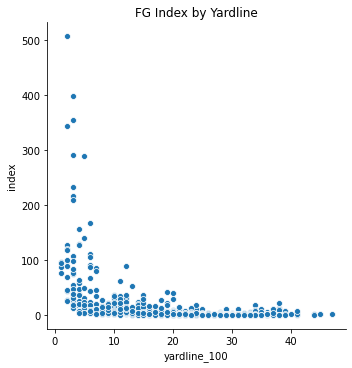

<Figure size 432x288 with 0 Axes>

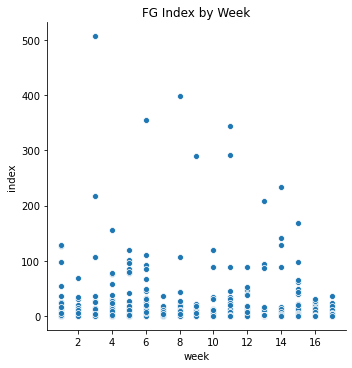

In [28]:
fg_data['index'] = bad_fg_index(fg_data)

display(fg_data.sort_values('index', ascending=False).head(10))

plt.figure()
_ = sns.relplot(x='yardline_100', y='index', data=fg_data)
plt.title('FG Index by Yardline')

plt.figure()
_ = sns.relplot(x='week', y='index', data=fg_data)
plt.title('FG Index by Week')

print("Mean Index:", fg_data['index'].agg(np.mean))

#These results don't exactly match up with my earlier analysis, but they are reasonably close with 6 of the top 10 
#being the same. Overall I think this index did a pretty good job and could be applied to the field goals of any
#season and remain fairly accurate. 
